In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist['data'], mnist['target']
(X.shape, y.shape)

((70000, 784), (70000,))

### Visualizing data

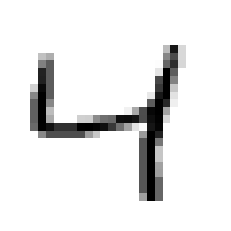

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[2]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [14]:
import numpy as np 
y = y.astype(np.uint8)
y[2]

4

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier of 5

In [16]:
y_train_5 =(y_train==5)
y_test_5 =(y_test==5)

In [20]:
## Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [24]:
sgd_clf.predict([X_train[0],X_train[2]])

array([ True, False])

### Cross Validation

In [24]:
import numpy as np

def split_train_test(data, ratio=0.2):
    # Ramdon Ratio data spliting 
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * ratio)
    test_data_indices = shuffled_indices[:test_set_size]
    train_data_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_data_indices], data.iloc[test_data_indices]


In [25]:
train_set, test_set = split_train_test(data)

In [26]:
len(train_set), len(test_set)

(16512, 4128)

In [31]:
from zlib import crc32

def test_set_check(identifier, ratio):
    # adding hashed identifier
    return crc32(np.int64(identifier)) & 0xffffffff < ratio * 2 **32

In [32]:
def split_train_test_by_id(data, test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~ in_test_set] , data.loc[in_test_set]

In [34]:
data_with_id = data.reset_index()
train_set, test_set = split_train_test_by_id(data_with_id, 0.2, 'index')

In [35]:
len(train_set),len(test_set)

(16512, 4128)

In [36]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [38]:
data_with_id['id'] = data_with_id['longitude']* 1000 + data_with_id['latitude']

In [39]:
train_set, test_set = split_train_test_by_id(data_with_id,0.2, 'id')

In [40]:
len(train_set), len(test_set)

(16322, 4318)

In [41]:
data_with_id['income_cat'] = pd.cut(data_with_id['median_income'], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1, 2, 3,4,5])

<AxesSubplot:>

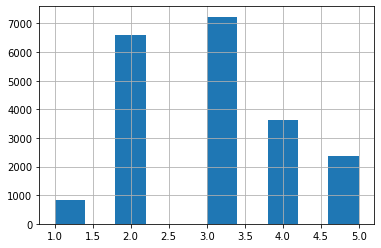

In [42]:
data_with_id['income_cat'].hist()

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

In [44]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42 )

In [45]:
for train_index, test_index in splitter.split(data_with_id,data_with_id['income_cat']):
    strat_train_set = data_with_id.loc[train_index]
    strat_test_set = data_with_id.loc[test_index]

In [46]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)* 100 

3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64

### income percentage by categories on the whole dataset

In [47]:
data_with_id['income_cat'].value_counts()/ len(data_with_id) * 100

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64

In [48]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [49]:
strat_train_set.columns

Index(['index', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'id'],
      dtype='object')

In [50]:
train_exp = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

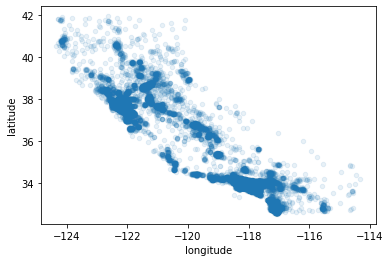

In [51]:
train_exp.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

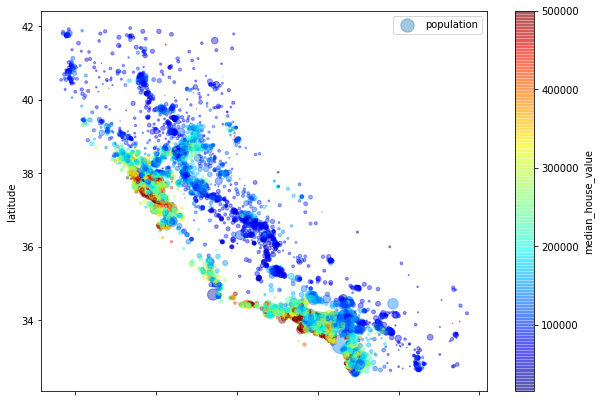

In [52]:
train_exp.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
      s=train_exp['population']/100, label='population', figsize=(10,7),
      c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,
      )
plt.legend()


In [53]:
train_exp['median_house_value'].head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [56]:
corr_matrix = train_exp.corr()

In [57]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
index                 0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
id                   -0.047632
latitude             -0.142724
Name: median_house_value, dtype: float64

In [58]:
corr_matrix.columns

Index(['index', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'id'],
      dtype='object')

In [59]:
from pandas.plotting import scatter_matrix

array([[<AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_income', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_house_valu

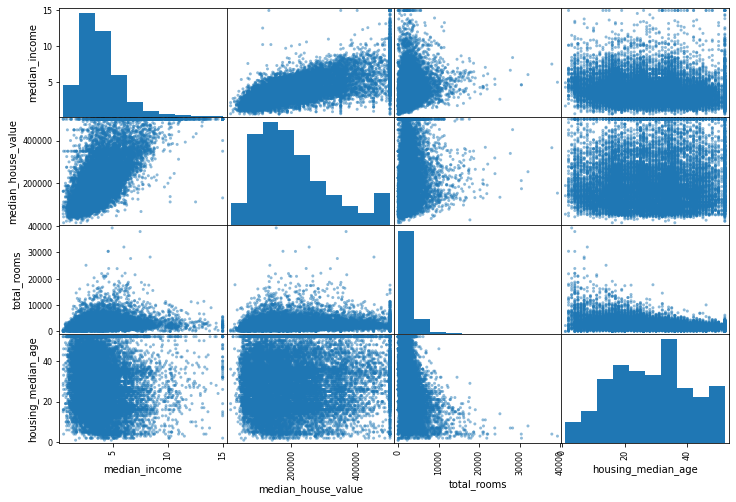

In [60]:
attributes =['median_income','median_house_value','total_rooms','housing_median_age']
scatter_matrix(train_exp[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

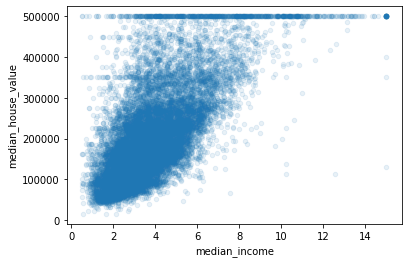

In [61]:
train_exp.plot(kind='scatter', x='median_income', y='median_house_value',alpha=0.1)

In [63]:
train_exp['rooms_per_household'] = train_exp['total_rooms']/train_exp['households']
train_exp['bedrooms_per_room'] = train_exp['total_bedrooms']/train_exp['total_rooms']
train_exp['population_per_household'] = train_exp['population']/ train_exp['households']

In [64]:
corr_matrix = train_exp.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
index                       0.067723
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
id                         -0.047632
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [65]:
housing = strat_train_set.drop(['median_house_value','index','id'], axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [66]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [67]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [68]:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [69]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [70]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [71]:
housing_cat = housing[['ocean_proximity']]
np.unique(housing_cat)

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [72]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [73]:
np.unique(housing_cat_encoded)

array([0., 1., 2., 3., 4.])

In [74]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)
housing_cat_1hot[:5]

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

### Custom transformer using BaseEstimator and TransformerMixin

In [127]:
from sklearn.base import BaseEstimator , TransformerMixin

In [128]:
room_ix, bedrooms_ix, population_ix, households_idx = 3, 4, 5, 6

In [129]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,room_ix] / X[:, households_idx]
        population_per_household = X[:, population_ix] / X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [130]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

In [131]:
housing_extra_attribs[:4]


array([[-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
        '<1H OCEAN', 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, 679.0, 108.0, 306.0, 113.0, 6.4214,
        '<1H OCEAN', 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, 1952.0, 471.0, 936.0, 462.0, 2.8621,
        'NEAR OCEAN', 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       [-119.61, 36.31, 25.0, 1847.0, 371.0, 1460.0, 353.0, 1.8839,
        'INLAND', 5.232294617563739, 4.135977337110481,
        0.20086626962642123]], dtype=object)

### Feature scaling with pipeline

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer',SimpleImputer(strategy='median')),
        ('attrib_adder',CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(housing_num.columns)
housing_num_tr[:3]

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')


array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ]])

### columns transformation using Column transformer

In [133]:
from sklearn.compose import ColumnTransformer
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [134]:
num_attribs = list(housing_num)
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [136]:
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ('num', num_pipeline,num_attribs),
        ('cat', one_hot_encoder, cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [137]:
housing_prepared[:2]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [124]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [141]:
def display_scores(scores):
    print('scores', scores)
    print('mean_score', scores.mean())
    print('std', scores.std())
    
    

### Cross validation using SVMRegressor

In [147]:
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)



SVR()

In [148]:
svr_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118580.68301157995

In [149]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)


scores [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
mean_score 118572.66762937943
std 2936.8775867949425


## Finetuning The model using GridSearh and RandomSearch 

### GridSearch Cross Validation for SVR Regressor

In [153]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [156]:
param_grid = [
    {'kernel':['linear','rbf'], 'C':[0.2, 1.0] , 'gamma':['scale','auto'] },
]
svr_reg = SVR()
svr_reg.get_params().keys()


dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [157]:
grid_search = RandomizedSearchCV(svr_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

/home/elie/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': [0.2, 1.0],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['linear', 'rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [158]:
grid_search.best_params_

{'kernel': 'linear', 'gamma': 'scale', 'C': 1.0}

In [159]:
grid_search.best_estimator_

SVR(kernel='linear')

### Evaluation scores 

In [161]:
cv_results = grid_search.cv_results_
for mean_score,params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

117593.10327393592 {'kernel': 'linear', 'gamma': 'scale', 'C': 0.2}
118861.76759107027 {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.2}
117593.10327393592 {'kernel': 'linear', 'gamma': 'auto', 'C': 0.2}
118861.91467444287 {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.2}
112571.9845974018 {'kernel': 'linear', 'gamma': 'scale', 'C': 1.0}
118631.71004256308 {'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}
112571.9845974018 {'kernel': 'linear', 'gamma': 'auto', 'C': 1.0}
118634.4106689143 {'kernel': 'rbf', 'gamma': 'auto', 'C': 1.0}
